In [25]:
def is_saliva(source):
    if source in ["1.saliva", "3.saliva_enriched"]:
        return False
    elif source in ["2.buccal", "4.buccal_enriched"]:
        return True
    else:
        raise ValueError(f"Invalid source: {source}")

def is_enriched(source):
    if source in ["1.saliva", "2.buccal"]:
        return False
    elif source in ["3.saliva_enriched", "4.buccal_enriched"]:
        return True
    else:
        raise ValueError(f"Invalid source: {source}")
    
def significance_stars(p_value):
    if p_value <= 0.00001:
        return "*****"
    elif p_value <= 0.0001:
        return "****"
    elif p_value <= 0.001:
        return "***"
    elif p_value <= 0.01:
        return "**"
    elif p_value <= 0.05:
        return "*"
    else:
        return f"{p_value:.3f}"  # Not significant
    
def get_stratification(PREV):
    stratification = ""
    prev_suffix = PREV.split("happy_")[-1]
    if prev_suffix == "above_0.05":
        stratification = "MAF>=0.05"
    elif prev_suffix == "below_0.05":
        stratification = "MAF<0.05"
    elif prev_suffix == "below_0.05_known":
        stratification = "MAF<0.05"
    elif prev_suffix == "above_0.01":
        stratification = "MAF>=0.01"
    elif prev_suffix == "below_0.01":
        stratification = "MAF<0.01"
    elif prev_suffix == "below_0.01_known":
        stratification = "MAF<0.01"
    elif prev_suffix == "novel":
        stratification = "novel"
    else:
        raise ValueError("incorrect prev_suffix")
    return stratification

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
import starbars

def get_combined_data(all_dict_key, summary_df_dict_raw, summary_df_dict_HROM_yesambi, summary_df_dict_eHOMD_yesambi, labels, snp_or_indel):
    combined_data = []
    # Iterate over the keys of the dictionaries (assuming all dictionaries have identical keys)
    for key in summary_df_dict_raw.keys():
        # Get dataframes from each dictionary for the current key
        df_raw = summary_df_dict_raw[key]
        df_yesambi = summary_df_dict_HROM_yesambi[key]
        df_noambi = summary_df_dict_eHOMD_yesambi[key]

        # Extract relevant metrics for SNP/INDEL and PASS/ALL
        for metric in ["METRIC.F1_Score"]:
            for filter_type in ["PASS"]:
                for variant_type in [snp_or_indel]:
                    # Extract data for the current filter and variant type
                    raw_values = df_raw[(df_raw["Type"] == variant_type) & (df_raw["Filter"] == filter_type)][metric].values
                    yesambi_values = df_yesambi[(df_yesambi["Type"] == variant_type) & (df_yesambi["Filter"] == filter_type)][metric].values
                    noambi_values = df_noambi[(df_noambi["Type"] == variant_type) & (df_noambi["Filter"] == filter_type)][metric].values

                    # Append data to combined_data
                    caller = all_dict_key[0]
                    prev = all_dict_key[1]
                    if len(raw_values) > 0 and len(yesambi_values) > 0:
                        combined_data.append((caller, prev, variant_type, filter_type, metric, labels[0], noambi_values[0]))
                        combined_data.append((caller, prev, variant_type, filter_type, metric, labels[1], raw_values[0]))
                        combined_data.append((caller, prev, variant_type, filter_type, metric, labels[2], yesambi_values[0]))
    return combined_data

def get_df(all_dict):
    # Initialize lists for data collection
    labels = ["eHOMD", "Raw", "HROM"]
    combined_data_all = []
    for all_dict_key in all_dict.keys():
        summary_df_dict_raw, summary_df_dict_HROM_yesambi, summary_df_dict_eHOMD_yesambi = all_dict[all_dict_key]

        combined_data_snp = get_combined_data(all_dict_key, summary_df_dict_raw, summary_df_dict_HROM_yesambi, summary_df_dict_eHOMD_yesambi, labels, "SNP")
        combined_data_all += combined_data_snp

        combined_data_indel = get_combined_data(all_dict_key, summary_df_dict_raw, summary_df_dict_HROM_yesambi, summary_df_dict_eHOMD_yesambi, labels, "INDEL")
        combined_data_all += combined_data_indel
    
    combined_df_all = pd.DataFrame(combined_data_all, columns=["Caller", "Prev", "Type", "Filter", "Metric", "Group", "Value"])
    return combined_df_all

    """
    # Map metric names to simplified labels
        metric_label_map = {
            "METRIC.F1_Score": "F1 Score",
            "METRIC.Precision": "Precision",
            "METRIC.Recall": "Recall"
        }
        combined_df["Metric"] = combined_df["Metric"].map(metric_label_map)

        # Create a single plot for all metrics
        plt.figure(figsize=(10, 8))

        custom_palette = {
            labels[0]: "#8da0cb",  # Light green
            labels[1]: "white",       # Green
            labels[2]: "seagreen" # Blue
        }

        # Plot boxplots
        ax = sns.boxplot(
            data=combined_df,
            x="Metric",
            y="Value",
            hue="Group",
            palette=custom_palette
        )

        # Customize the plot
        plt.title(f"Metrics for {snp_or_indel} {stratification}")
        plt.xlabel("Metrics")
        plt.ylabel("Value")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Method", loc="lower left")

        # Add statistical annotations using Wilcoxon signed-rank test
        annotations = []
        for metric in ["F1 Score", "Precision", "Recall"]:
            for group_pair in [(labels[1], labels[0]), (labels[1], labels[2]), (labels[0], labels[2])]:  # Add (labels[0], labels[2])
                # Filter data for statistical test
                group1 = combined_df[(combined_df["Metric"] == metric) & (combined_df["Group"] == group_pair[0])]["Value"]
                group2 = combined_df[(combined_df["Metric"] == metric) & (combined_df["Group"] == group_pair[1])]["Value"]

                # Perform Wilcoxon signed-rank test
                if len(group1) > 0 and len(group2) > 0 and len(group1) == len(group2):
                    stat, p_value = wilcoxon(group1, group2, alternative="less")
                    annotations.append(((group_pair[0], metric), (group_pair[1], metric), significance_stars(p_value)))

        # Adding statistical annotations
        starbars.draw_annotation(annotations)

        plt.tight_layout()
        plt.show()
"""

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
import starbars

def boxplot_decontam_performance(summary_df_dict_raw, summary_df_dict_HROM_yesambi, summary_df_dict_eHOMD_yesambi, snp_or_indel, stratification):
    # Initialize lists for data collection
    combined_data = []
    labels = ["Raw", "eHOMD", "HROM"]

    # Iterate over the keys of the dictionaries (assuming all dictionaries have identical keys)
    for key in summary_df_dict_raw.keys():
        # Get dataframes from each dictionary for the current key
        df_raw = summary_df_dict_raw[key]
        df_yesambi = summary_df_dict_HROM_yesambi[key]
        df_noambi = summary_df_dict_eHOMD_yesambi[key]

        # Extract relevant metrics for SNP/INDEL and PASS/ALL
        for metric in ["METRIC.F1_Score", "METRIC.Precision", "METRIC.Recall"]:
            for filter_type in ["PASS"]:
                for variant_type in [snp_or_indel]:
                    # Extract data for the current filter and variant type
                    raw_values = df_raw[(df_raw["Type"] == variant_type) & (df_raw["Filter"] == filter_type)][metric].values
                    yesambi_values = df_yesambi[(df_yesambi["Type"] == variant_type) & (df_yesambi["Filter"] == filter_type)][metric].values
                    noambi_values = df_noambi[(df_noambi["Type"] == variant_type) & (df_noambi["Filter"] == filter_type)][metric].values

                    # Append data to combined_data
                    if len(raw_values) > 0 and len(yesambi_values) > 0:
                        combined_data.append((key, variant_type, filter_type, metric, labels[0], raw_values[0]))
                        combined_data.append((key, variant_type, filter_type, metric, labels[1], noambi_values[0]))
                        combined_data.append((key, variant_type, filter_type, metric, labels[2], yesambi_values[0]))

    # Create a DataFrame for plotting
    combined_df = pd.DataFrame(combined_data, columns=["Key", "Type", "Filter", "Metric", "Group", "Value"])
    
    # Map metric names to simplified labels
    metric_label_map = {
        "METRIC.F1_Score": "F1 Score",
        "METRIC.Precision": "Precision",
        "METRIC.Recall": "Recall"
    }
    combined_df["Metric"] = combined_df["Metric"].map(metric_label_map)

    # Print mean and median for each group
    print("Mean, Median, and p-values for each Group:")
    for metric in ["F1 Score", "Precision", "Recall"]:
        print(f"\nMetric: {metric}")
        for group in labels:
            group_values = combined_df[(combined_df["Metric"] == metric) & (combined_df["Group"] == group)]["Value"]
            if not group_values.empty:
                print(f"  {group}: Mean = {group_values.mean():.7f}, Median = {group_values.median():.7f}")

    # Define output file name
    output_tsv_name = "/home/zunuan/"
    if ">=" in stratification:
        output_tsv_name += "common_"
    elif "<" in stratification:
        output_tsv_name += "rare_"
    elif "novel" in stratification:
        output_tsv_name += "novel_"
    else:
        raise ValueError()
    output_tsv_name += snp_or_indel
    output_tsv_name += ".tsv"

    combined_df.to_csv(output_tsv_name, sep="\t")

    # Create a single plot for all metrics
    plt.figure(figsize=(8, 8))

    custom_palette = {
        labels[0]: "white",
        labels[1]: "#1f77b4",
        labels[2]: "#ff7f0e"
    }
    
    # Plot boxplots
    ax = sns.boxplot(
        data=combined_df,
        x="Metric",
        y="Value",
        hue="Group",
        palette=custom_palette
    )

    # Customize the plot
    plt.title(f"Metrics for {snp_or_indel} {stratification}")
    plt.xlabel("Metrics")
    plt.ylabel("Value")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Method", loc="lower left")

    # Add statistical annotations using Wilcoxon signed-rank test
    annotations = []
    for metric in ["F1 Score", "Precision", "Recall"]:
        print(f"\nWilcoxon Signed-Rank Test Results for {metric}:")
        for group_pair in [(labels[0], labels[1]), (labels[0], labels[2]), (labels[1], labels[2])]:
            # Filter data for statistical test
            group1 = combined_df[(combined_df["Metric"] == metric) & (combined_df["Group"] == group_pair[0])]["Value"]
            group2 = combined_df[(combined_df["Metric"] == metric) & (combined_df["Group"] == group_pair[1])]["Value"]

            # Perform Wilcoxon signed-rank test
            if len(group1) > 0 and len(group2) > 0 and len(group1) == len(group2):
                stat, p_value = wilcoxon(group1, group2, alternative="less")
                print(f"  {group_pair[0]} vs. {group_pair[1]}: p-value = {p_value:.7f}")
                annotations.append(((group_pair[0], metric), (group_pair[1], metric), significance_stars(p_value)))

    # Adding statistical annotations
    starbars.draw_annotation(annotations)
    
    plt.tight_layout()
    plt.savefig(f"boxplot_{snp_or_indel}_{stratification}.pdf", format="pdf", bbox_inches="tight")
    plt.show()


Mean, Median, and p-values for each Group:

Metric: F1 Score
  Raw: Mean = 0.9909037, Median = 0.9912465
  eHOMD: Mean = 0.9909354, Median = 0.9912440
  HROM: Mean = 0.9909382, Median = 0.9912475

Metric: Precision
  Raw: Mean = 0.9906301, Median = 0.9908005
  eHOMD: Mean = 0.9906895, Median = 0.9908125
  HROM: Mean = 0.9906934, Median = 0.9908180

Metric: Recall
  Raw: Mean = 0.9911781, Median = 0.9914625
  eHOMD: Mean = 0.9911817, Median = 0.9914390
  HROM: Mean = 0.9911832, Median = 0.9914375

Wilcoxon Signed-Rank Test Results for F1 Score:
  Raw vs. eHOMD: p-value = 0.0415805
  Raw vs. HROM: p-value = 0.0045929
  eHOMD vs. HROM: p-value = 0.0153358

Wilcoxon Signed-Rank Test Results for Precision:
  Raw vs. eHOMD: p-value = 0.0020905
  Raw vs. HROM: p-value = 0.0003267
  eHOMD vs. HROM: p-value = 0.0221558

Wilcoxon Signed-Rank Test Results for Recall:
  Raw vs. eHOMD: p-value = 0.3881686
  Raw vs. HROM: p-value = 0.4104462
  eHOMD vs. HROM: p-value = 0.2159723


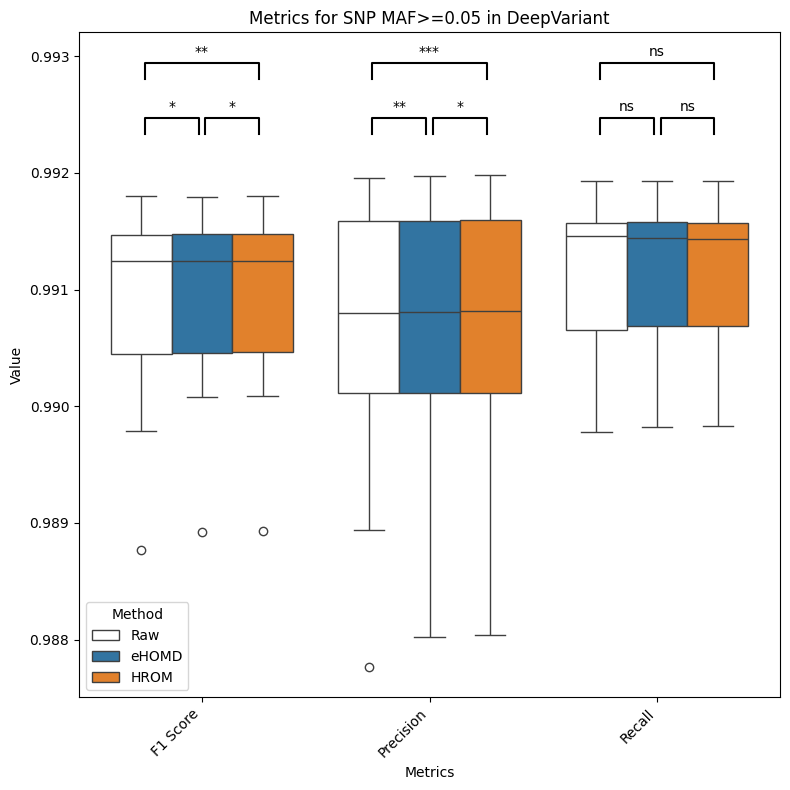

Mean, Median, and p-values for each Group:

Metric: F1 Score
  Raw: Mean = 0.9535636, Median = 0.9556220
  eHOMD: Mean = 0.9537146, Median = 0.9556595
  HROM: Mean = 0.9537103, Median = 0.9556540

Metric: Precision
  Raw: Mean = 0.9533366, Median = 0.9541055
  eHOMD: Mean = 0.9536246, Median = 0.9545600
  HROM: Mean = 0.9536176, Median = 0.9545600

Metric: Recall
  Raw: Mean = 0.9538351, Median = 0.9561400
  eHOMD: Mean = 0.9538477, Median = 0.9561475
  HROM: Mean = 0.9538463, Median = 0.9561510

Wilcoxon Signed-Rank Test Results for F1 Score:
  Raw vs. eHOMD: p-value = 0.0000458
  Raw vs. HROM: p-value = 0.0000153
  eHOMD vs. HROM: p-value = 0.8258057

Wilcoxon Signed-Rank Test Results for Precision:
  Raw vs. eHOMD: p-value = 0.0000153
  Raw vs. HROM: p-value = 0.0000153
  eHOMD vs. HROM: p-value = 0.8942871

Wilcoxon Signed-Rank Test Results for Recall:
  Raw vs. eHOMD: p-value = 0.6471405
  Raw vs. HROM: p-value = 0.6471405
  eHOMD vs. HROM: p-value = 0.6090240


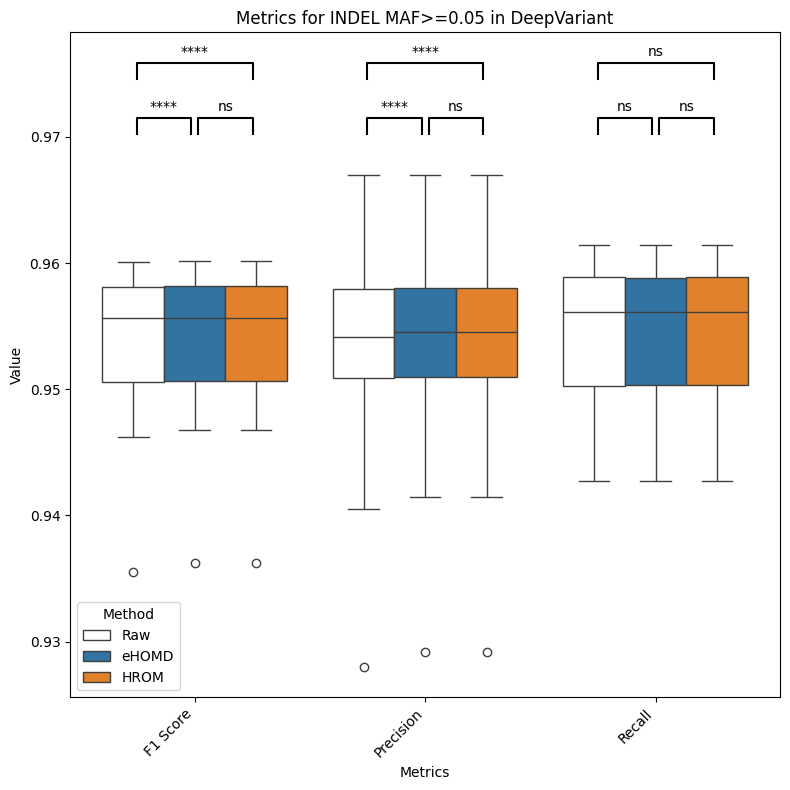

----------------------------------------------------------------------------------------------------------
Mean, Median, and p-values for each Group:

Metric: F1 Score
  Raw: Mean = 0.8348374, Median = 0.8348580
  eHOMD: Mean = 0.8339730, Median = 0.8336870
  HROM: Mean = 0.8349393, Median = 0.8348480

Metric: Precision
  Raw: Mean = 0.8348518, Median = 0.8345285
  eHOMD: Mean = 0.8333509, Median = 0.8324320
  HROM: Mean = 0.8347329, Median = 0.8343945

Metric: Recall
  Raw: Mean = 0.8348354, Median = 0.8358335
  eHOMD: Mean = 0.8346073, Median = 0.8353520
  HROM: Mean = 0.8351590, Median = 0.8362460

Wilcoxon Signed-Rank Test Results for F1 Score:
  Raw vs. eHOMD: p-value = 0.9997864
  Raw vs. HROM: p-value = 0.3160858
  eHOMD vs. HROM: p-value = 0.0000153

Wilcoxon Signed-Rank Test Results for Precision:
  Raw vs. eHOMD: p-value = 1.0000000
  Raw vs. HROM: p-value = 0.9711609
  eHOMD vs. HROM: p-value = 0.0000153

Wilcoxon Signed-Rank Test Results for Recall:
  Raw vs. eHOMD: p-value

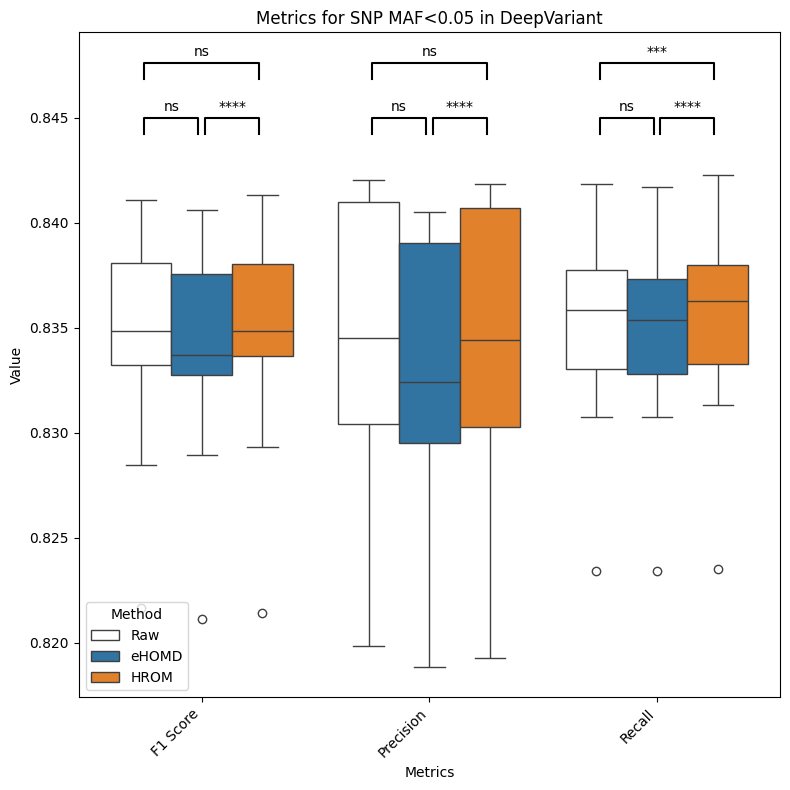

Mean, Median, and p-values for each Group:

Metric: F1 Score
  Raw: Mean = 0.7676964, Median = 0.7685670
  eHOMD: Mean = 0.7680431, Median = 0.7689550
  HROM: Mean = 0.7680343, Median = 0.7688200

Metric: Precision
  Raw: Mean = 0.7683531, Median = 0.7714185
  eHOMD: Mean = 0.7685716, Median = 0.7714875
  HROM: Mean = 0.7686497, Median = 0.7715745

Metric: Recall
  Raw: Mean = 0.7674214, Median = 0.7728190
  eHOMD: Mean = 0.7678994, Median = 0.7733445
  HROM: Mean = 0.7678051, Median = 0.7731110

Wilcoxon Signed-Rank Test Results for F1 Score:
  Raw vs. eHOMD: p-value = 0.0077515
  Raw vs. HROM: p-value = 0.0106964
  eHOMD vs. HROM: p-value = 0.7017059

Wilcoxon Signed-Rank Test Results for Precision:
  Raw vs. eHOMD: p-value = 0.0416260
  Raw vs. HROM: p-value = 0.0031433
  eHOMD vs. HROM: p-value = 0.1057129

Wilcoxon Signed-Rank Test Results for Recall:
  Raw vs. eHOMD: p-value = 0.0002899
  Raw vs. HROM: p-value = 0.0193176
  eHOMD vs. HROM: p-value = 0.9673004


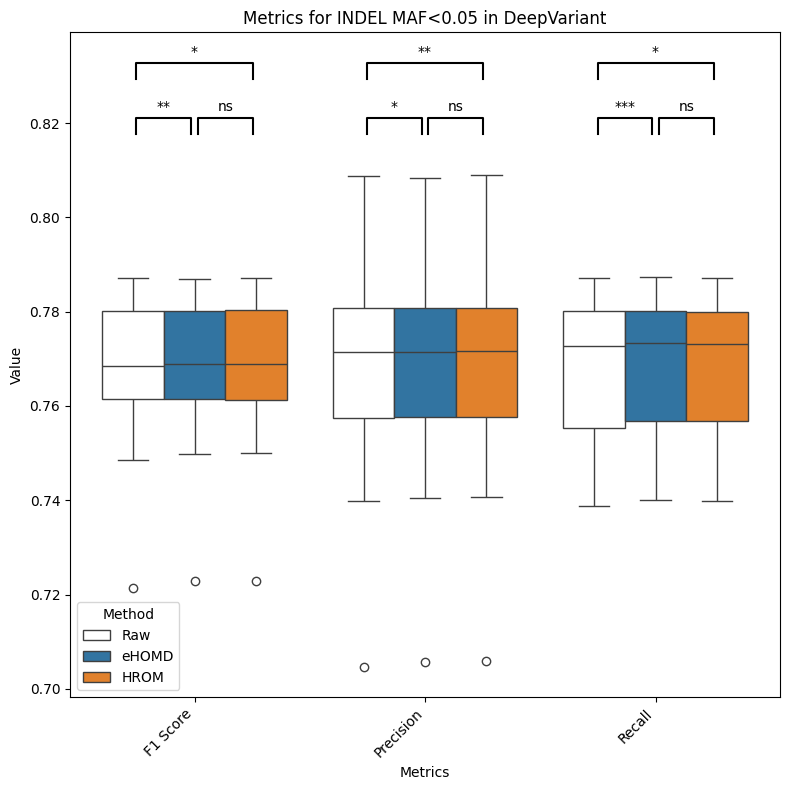

----------------------------------------------------------------------------------------------------------


In [32]:
import itertools
import pandas as pd

# parameters for base directory
REFERENCE = "2.no_alt_GRCh38"

CALLER = "2.DV"
# CALLER = "4.HC_default"
PREV = "5-6.happy_below_0.01_known"
NEXT = "6.visualization"


PREV_LIST = ["5-1.happy_above_0.05", "5-2.happy_below_0.05"]

for PREV in PREV_LIST:
    # parsed based directory
    DATA_DIR = "/home/zunuan/anaconda3/salfilter/data"
    IN_BASE_DIR = f"{DATA_DIR}/{REFERENCE}/{CALLER}/{PREV}"
    OUT_BASE_DIR = f"{DATA_DIR}/{REFERENCE}/{CALLER}/{NEXT}"

    # options for the happy tool
    ci_alpha_values = [0.05] # 0.05, 0.01, 0.001
    engine_values = ["xcmp"] # "xcmp", "vcfeval"
    leftshift_options = ["no-ls"] # "no-ls", "ls"
    decompose_options = ["dc"] # "dc", "no-dc"

    # lists for the methods
    decontam_list = ["raw", "HROM", "eHOMD"]
    sample_list = ["PGPC-02", "PGPC-05", "PGPC-06", "PGPC-50"]
    source_list = ["1.saliva", "2.buccal", "3.saliva_enriched", "4.buccal_enriched"]

    # actual summary file name. Should be identical. 
    summary_file_name = "happy.summary.csv" 

    
    for ci_alpha, engine, ls, dc in itertools.product(
        ci_alpha_values, engine_values, leftshift_options, decompose_options
    ):
        ###################################
        ## Initialize dicts for plotting ##
        ###################################

        # raw vs yesambi vs noambi
        summary_df_dict_raw = {}
        summary_df_dict_HROM_yesambi = {}
        summary_df_dict_eHOMD_yesambi = {}
        # saliva vs buccal
        summary_df_dict_saliva = {}
        summary_df_dict_buccal = {}
        # nonenriched vs enriched
        summary_df_dict_nonenriched = {}
        summary_df_dict_enriched = {}

        ############################
        ## Assign summary to dict ##
        ############################
        for decontam, sample, source in itertools.product(
            decontam_list, sample_list, source_list
        ):
            # Parse the full path to each individual summary file.
            summary_dir_name = f"{decontam}_{sample}"
            summary_full_path = f"{IN_BASE_DIR}/{summary_dir_name}/{source}/{summary_file_name}"

            # Read the summary file.
            columns_to_extract = ["Type", "Filter", "METRIC.F1_Score", "METRIC.Precision", "METRIC.Recall"]

            try:
                summary_df = pd.read_csv(summary_full_path).loc[:,columns_to_extract]
            except FileNotFoundError as e:
                print(f"ERROR : file not found: {summary_full_path}")
                print(f"Error: {e}")
                continue
            #    Type   Filter  METRIC.F1_Score   METRIC.Precision   METRIC.Recall
            # 0  INDEL  ALL     0.893005          0.850281           0.940248
            # 1  INDEL  PASS    0.910230          0.889809           0.931610
            # 2  SNP    ALL     0.942941          0.901244           0.988683
            # 3  SNP    PASS    0.976923          0.976194           0.977653

            # Assign datapoints to each dictionary
            summary_dict_key = (sample, source)
            # Assign datapoints for raw vs yesambi vs noambi
            if decontam == "raw":
                summary_df_dict_raw[summary_dict_key] = summary_df
            elif decontam == "HROM":
                summary_df_dict_HROM_yesambi[summary_dict_key] = summary_df
            elif decontam == "eHOMD":
                summary_df_dict_eHOMD_yesambi[summary_dict_key] = summary_df
            else:
                raise ValueError(f"Invalid decontam: {decontam}")

            # Assign datapoints for saliva vs buccal
            if is_saliva(source):
                summary_df_dict_saliva[summary_dict_key] = summary_df
            else:
                summary_df_dict_buccal[summary_dict_key] = summary_df
            
            # Assign datapoints for nonenriched vs enriched
            if not is_enriched(source):
                summary_df_dict_nonenriched[summary_dict_key] = summary_df
            else:
                summary_df_dict_enriched[summary_dict_key] = summary_df

        #summary_dir_name = f"ci{ci_alpha}_{engine}_{ls}_{dc}_{decontam}_{sample}"
        #print(f"Settings are : {summary_dir_name}")

        stratification = get_stratification(PREV)
        
        if CALLER == "2.DV":
            stratification += " in DeepVariant"
        elif CALLER == "4.HC_default":
            stratification += " in GATK"
        
        
        boxplot_decontam_performance(summary_df_dict_raw, summary_df_dict_HROM_yesambi, summary_df_dict_eHOMD_yesambi, "SNP", stratification)
        boxplot_decontam_performance(summary_df_dict_raw, summary_df_dict_HROM_yesambi, summary_df_dict_eHOMD_yesambi, "INDEL", stratification)

        print("----------------------------------------------------------------------------------------------------------")
        
        
        #################################
        ## Pass dict to each plot func ##
        #################################

        # Compares (raw vs yesambi vs noambi) per group
        # Iterations : 
        # (METRIC.F1_Score, METRIC.Precision, METRIC.Recall) : for each metric.
        # (PASS) : for only PASS variants.
        # (SNP, INDEL) : for each variant type.
        # boxplot_decontam_performance(summary_df_dict_raw, summary_df_dict_HROM_yesambi, summary_df_dict_eHOMD_yesambi)

        # saliva vs buccal
        # boxplot_source_performance(summary_df_dict_saliva, summary_df_dict_buccal)

        # nonenriched vs enriched
        # boxplot_enriched_performance(summary_df_dict_nonenriched, summary_df_dict_enriched)




In [1]:
import numpy as np
from scipy.stats import wilcoxon

# Example data: Paired samples (before and after treatment)

before = np.array([
    3853631, 3848320, 3854383, 3848445,
    3858014, 3848445, 3868520, 3869050,
    3898699, 3896070, 3897565, 3899152,
    3855685, 3858310, 3858357, 3864029
])

after = np.array([
    3853389, 3848052, 3854356, 3848372,
    3858279, 3867643, 3868301, 3868909,
    3898752, 3896024, 3897478, 3899323,
    3856976, 3858260, 3858311, 3863947
])

# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(before, after)

# Display results
print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")




Wilcoxon signed-rank test statistic: 59.0
P-value: 0.668548583984375


In [5]:
import numpy as np
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel

# Example data: Paired samples (before and after treatment)

before = np.array([
    963856, 967063, 975307, 977944,
    941864, 977944, 978125, 987180,
    980216, 985471, 990803, 997711,
    959455, 976831, 975755, 993657
])

after = np.array([
    963939, 967088, 975468, 978052,
    942491, 975805, 978424, 987261,
    980393, 985682, 990970, 997833,
    960007, 976926, 976270, 993733
])

# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(before, after)

# Display results
print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

Wilcoxon signed-rank test statistic: 16.0
P-value: 0.005157470703125


In [ ]:
def validate_boxplot_decontam_performance